# Import the libraries and download the dependings

In [1]:
import os
import numpy as np
import math
import json
from functools import partial
from PIL import Image
from collections import defaultdict


import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

from tqdm.auto import tqdm

# comment this if you are not using colab tpu
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

import jax
import jax.numpy as jnp
from jax import random

try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch
import torch
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10




# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial15_jax"

# Seeding for random operations
main_rng = random.PRNGKey(42)

print("Device:", jax.devices()[0])

     |████████████████████████████████| 189 kB 5.3 MB/s 
     |████████████████████████████████| 8.3 MB 55.3 MB/s 
     |████████████████████████████████| 145 kB 56.5 MB/s 
     |████████████████████████████████| 237 kB 55.7 MB/s 
     |████████████████████████████████| 51 kB 6.0 MB/s 
     |████████████████████████████████| 85 kB 3.4 MB/s 
Device: TPU_0(host=0,(0,0,0,0))


# Downloading the dataset and do augmentation and split

In [15]:
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img


def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

test_transform = image_to_numpy
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      image_to_numpy
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for training and validation
train_loader = data.DataLoader(train_set,
                batch_size=128,
                shuffle=True,
                drop_last=True,
                collate_fn=numpy_collate,
                num_workers=8,
                persistent_workers=True)
val_loader = data.DataLoader(val_set,
                batch_size=128,
                shuffle=False,
                drop_last=False,
                collate_fn=numpy_collate,
                num_workers=4,
                persistent_workers=True)
test_loader = data.DataLoader(test_set,
                batch_size=128,
                shuffle=False,
                drop_last=False,
                collate_fn=numpy_collate,
                num_workers=4,
                persistent_workers=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Visualize some examples

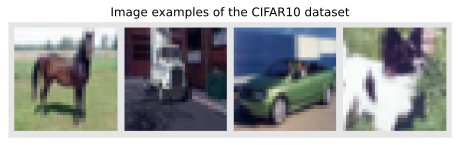

In [16]:
def numpy_to_torch(array):
    array = jax.device_get(array)
    tensor = torch.from_numpy(array)
    tensor = tensor.permute(0, 3, 1, 2)
    return tensor

NUM_IMAGES = 4
CIFAR_images = np.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], axis=0)
img_grid = torchvision.utils.make_grid(numpy_to_torch(CIFAR_images),
                                       nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

# Split image into patch

In [17]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, H, W, C]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, H, W, C = x.shape
    x = x.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C)
    x = x.transpose(0, 1, 3, 2, 4, 5)    # [B, H', W', p_H, p_W, C]
    x = x.reshape(B, -1, *x.shape[3:])   # [B, H'*W', p_H, p_W, C]
    if flatten_channels:
        x = x.reshape(B, x.shape[1], -1) # [B, H'*W', p_H*p_W*C]
    return x

# Visualize the patch

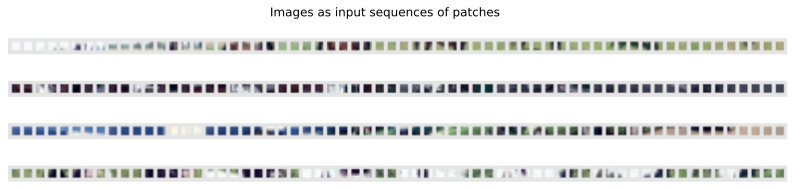

In [18]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(numpy_to_torch(img_patches[i]),
                                           nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

# Attention Block

In [19]:
class AttentionBlock(nn.Module):
    embed_dim : int   # Dimensionality of input and attention feature vectors
    hidden_dim : int  # Dimensionality of hidden layer in feed-forward network
    num_heads : int   # Number of heads to use in the Multi-Head Attention block
    dropout_prob : float = 0.0  # Amount of dropout to apply in the feed-forward network

    def setup(self):
        self.attn = nn.MultiHeadDotProductAttention(num_heads=self.num_heads)
        self.linear = [
            nn.Dense(self.hidden_dim),
            nn.gelu,
            nn.Dropout(self.dropout_prob),
            nn.Dense(self.embed_dim)
        ]
        self.layer_norm_1 = nn.LayerNorm()
        self.layer_norm_2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_prob)

    def __call__(self, x, train=True):
        inp_x = self.layer_norm_1(x)
        attn_out = self.attn(inputs_q=inp_x, inputs_kv=inp_x)
        x = x + self.dropout(attn_out, deterministic=not train)

        linear_out = self.layer_norm_2(x)
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, nn.Dropout) else l(linear_out, deterministic=not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        return x

# Test the Attention Block

In [20]:
## Test AttentionBlock implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create attention block
attnblock = AttentionBlock(embed_dim=128, hidden_dim=512, num_heads=4, dropout_prob=0.1)
# Initialize parameters of attention block with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = attnblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, True)['params']
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = attnblock.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del attnblock, params

Out (3, 16, 128)


# ViT Block

In [21]:
class VisionTransformer(nn.Module):
    embed_dim : int     # Dimensionality of input and attention feature vectors
    hidden_dim : int    # Dimensionality of hidden layer in feed-forward network
    num_heads : int     # Number of heads to use in the Multi-Head Attention block
    num_channels : int  # Number of channels of the input (3 for RGB)
    num_layers : int    # Number of layers to use in the Transformer
    num_classes : int   # Number of classes to predict
    patch_size : int    # Number of pixels that the patches have per dimension
    num_patches : int   # Maximum number of patches an image can have
    dropout_prob : float = 0.0  # Amount of dropout to apply in the feed-forward network

    def setup(self):
        # Layers/Networks
        self.input_layer = nn.Dense(self.embed_dim)
        self.transformer = [AttentionBlock(self.embed_dim,
                                           self.hidden_dim,
                                           self.num_heads,
                                           self.dropout_prob) for _ in range(self.num_layers)]
        self.mlp_head = nn.Sequential([
            nn.LayerNorm(),
            nn.Dense(self.num_classes)
        ])
        self.dropout = nn.Dropout(self.dropout_prob)

        # Parameters/Embeddings
        self.cls_token = self.param('cls_token',
                                    nn.initializers.normal(stddev=1.0),
                                    (1, 1, self.embed_dim))
        self.pos_embedding = self.param('pos_embedding',
                                        nn.initializers.normal(stddev=1.0),
                                        (1, 1+self.num_patches, self.embed_dim))


    def __call__(self, x, train=True):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, axis=0)
        x = jnp.concatenate([cls_token, x], axis=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x, deterministic=not train)
        for attn_block in self.transformer:
            x = attn_block(x, train=train)

        # Perform classification prediction
        cls = x[:,0]
        out = self.mlp_head(cls)
        return out

# Test the ViT Block Implementation

In [22]:
## Test VisionTransformer implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (5, 32, 32, 3))
# Create vision transformer
visntrans = VisionTransformer(embed_dim=128,
                              hidden_dim=512,
                              num_heads=4,
                              num_channels=3,
                              num_layers=6,
                              num_classes=10,
                              patch_size=4,
                              num_patches=64,
                              dropout_prob=0.1)
# Initialize parameters of the Vision Transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = visntrans.init({'params': init_rng, 'dropout': dropout_init_rng}, x, True)['params']
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = visntrans.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del visntrans, params

Out (5, 10)


# Trainer Block

In [23]:
class TrainerModule:

    def __init__(self, exmp_imgs, lr=1e-3, weight_decay=0.01, seed=42, **model_hparams):
        """
        Module for summarizing all training functionalities for classification on CIFAR10.

        Inputs:
            exmp_imgs - Example imgs, used as input to initialize the model
            lr - Learning rate of the optimizer to use
            weight_decay - Weight decay to use in the optimizer
            seed - Seed to use in the model initialization
        """
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.seed = seed
        self.rng = jax.random.PRNGKey(self.seed)
        # Create empty model. Note: no parameters yet
        self.model = VisionTransformer(**model_hparams)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, 'ViT/')
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_imgs)

    def create_functions(self):
        # Function to calculate the classification loss and accuracy for a model
        def calculate_loss(params, rng, batch, train):
            imgs, labels = batch
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params},
                                      imgs,
                                      train=train,
                                      rngs={'dropout': dropout_apply_rng})
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, rng)
        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            # Get loss, gradients for loss, and other outputs of loss function
            (loss, (acc, rng)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            # Update parameters and batch statistics
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        # Eval function
        def eval_step(state, rng, batch):
            # Return the accuracy for a single batch
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return rng, acc
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        # Initialize model
        self.rng, init_rng, dropout_init_rng = random.split(self.rng, 3)
        self.init_params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng},
                                           exmp_imgs,
                                           train=True)['params']
        self.state = None

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # We decrease the learning rate by a factor of 0.1 after 60% and 85% of the training
        lr_schedule = optax.piecewise_constant_schedule(
            init_value=self.lr,
            boundaries_and_scales=
                {int(num_steps_per_epoch*num_epochs*0.6): 0.1,
                 int(num_steps_per_epoch*num_epochs*0.85): 0.1}
        )
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            optax.adamw(lr_schedule, weight_decay=self.weight_decay)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(
                                       apply_fn=self.model.apply,
                                       params=self.init_params if self.state is None else self.state.params,
                                       tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval accuracy
        best_eval = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(epoch=epoch_idx)
            if epoch_idx % 2 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/acc', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_eval:
                    best_eval = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(list)
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, self.rng, loss, acc = self.train_step(self.state, self.rng, batch)
            metrics['loss'].append(loss)
            metrics['acc'].append(acc)
        for key in metrics:
            avg_val = np.stack(jax.device_get(metrics[key])).mean()
            self.logger.add_scalar('train/'+key, avg_val, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg loss
        correct_class, count = 0, 0
        for batch in data_loader:
            self.rng, acc = self.eval_step(self.state, self.rng, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target=self.state.params,
                                    step=step,
                                    overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'ViT.ckpt'), target=None)
        self.state = train_state.TrainState.create(
                                       apply_fn=self.model.apply,
                                       params=params,
                                       tx=self.state.tx if self.state else optax.adamw(self.lr)  # Default optimizer
                                      )

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'ViT.ckpt'))

In [24]:
def train_model(*args, num_epochs=200, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test': test_acc}

# Train the model

In [25]:
model, results = train_model(exmp_imgs=next(iter(train_loader))[0],
                             embed_dim=256,
                             hidden_dim=512,
                             num_heads=8,
                             num_layers=6,
                             patch_size=4,
                             num_channels=3,
                             num_patches=64,
                             num_classes=10,
                             dropout_prob=0.2,
                             lr=3e-4)
print("ViT results", results)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ViT results {'val': 0.7847999930381775, 'test': 0.7835999727249146}
